In [116]:
import h5py
import scipy
import numpy as np
import os
import zlib
import msgpack
from sklearn.utils import sparsefuncs
import pickle
import json

def read_compressed_json(json_path):
	if not os.path.isfile(json_path):
		return {}
	with open(json_path, 'rb') as f:
		o = f.read()
		o = zlib.decompress(o)
		o = msgpack.unpackb(o, strict_map_key=False)
		return o

In [117]:
GENES_ANNOTATION = read_compressed_json('/home/ub-sonvo-25d094476064960/genes_annotation.json.gz')
N_GENES = GENES_ANNOTATION['n_genes']
DEFAULT_SIZE_FACTOR = 10000
ROOT_DIR = '/home/ub-sonvo-25d094476064960/celltype_prediction'
# TRAINED_STUDIES = open(ROOT_DIR + '/studies_idx_HVG.txt').read().splitlines()
TRAINED_STUDIES = sorted(os.listdir('/home/ub-sonvo-25d094476064960/celltype_prediction/camel_2'))

In [118]:
GENES_ANNOTATION.keys()

dict_keys(['n_genes', 'idx2name', 'name2idx', 'idx_blacklist', 'genes_alias'])

In [119]:
def _normalize_total(csr_matrix, counts):
	csr_matrix = csr_matrix.astype(np.float32)
	counts += counts == 0
	counts = counts / 10000
	sparsefuncs.inplace_row_scale(csr_matrix, 1 / counts)
	return csr_matrix


def normalize_total(csr_cxg, n_genes=N_GENES):
    csr_cxg = csr_cxg[:, :n_genes]
    counts_per_cell = csr_cxg.sum(1)
    counts_per_cell = np.ravel(counts_per_cell)

    csr_cxg = _normalize_total(csr_cxg, counts_per_cell)
    csr_cxg.data = np.log1p(csr_cxg.data)

    return csr_cxg


def convert_library_size(csr_cxg, n_genes=N_GENES, size_factor=DEFAULT_SIZE_FACTOR):
    res = []
    for i in range(50):
        res.append(
            np.sum(
                np.expm1(
                    csr_cxg.data[csr_cxg.indptr[i] : csr_cxg.indptr[i+1]]
                )
            )
        )
    res = [np.round(i) for i in res]
    ori_size_factor = np.unique(res)
    upper_bound = ori_size_factor[0] + ori_size_factor[0] * 0.1
    lower_bount = ori_size_factor[0] - ori_size_factor[0] * 0.1

    if np.all(ori_size_factor > lower_bount) and np.all(ori_size_factor < upper_bound):
        csr_cxg = csr_cxg[:, :n_genes]
        if DEFAULT_SIZE_FACTOR < upper_bound and DEFAULT_SIZE_FACTOR > lower_bount:
            return csr_cxg
            
        csr_cxg.data = np.expm1(csr_cxg.data)
        csr_cxg.data = csr_cxg.data * (DEFAULT_SIZE_FACTOR / ori_size_factor[0])
        csr_cxg.data = np.log1p(csr_cxg.data)
        return csr_cxg
        
    print('cannot find the library size:', ori_size_factor)
    return None

In [50]:
genes_bool = np.load('trained_data_2/genes_bool.npy')
original_meta_arr = np.load('trained_data_2/trained_meta_celltypes_HVG.npy')
studies_idx_arr = np.load('trained_data_2/studies_idx_arr.npy')

In [120]:
new_tree_genes_bool = np.load('trained_data_2/new_tree_genes_bool_2.npy')
new_tree_studies_idx_arr = np.load('trained_data_2/new_tree_studies_idx_arr.npy')
new_tree_major = np.load('trained_data_2/new_tree_major_HVG.npy')
# new_tree_sub = np.load('trained_data_2/new_tree_sub.npy')

In [122]:
np.sum(np.array(GENES_ANNOTATION['idx2name'])[new_tree_genes_bool] == 'TRDC')

1

In [123]:
x, y = np.unique(new_tree_major, return_counts=True)
x = x[np.argsort(y)[::-1]]
x = [TERM_MAPPING['idx2name'][i] for i in x]
y = y[np.argsort(y)[::-1]]
df = pd.DataFrame({'ct': x, 'count': y})
df

,ct,count
0,Unassigned,4232842
1,"CD4-positive, alpha-beta T cell",903363
2,glial cell,642631
3,neural cell,543610
4,B cell,323100
5,macrophage,309522
6,plasma cell,272811
7,epithelial cell,251253
8,innate lymphoid cell,211807
9,glutamatergic neuron,202082


In [ ]:
filtered_indptr = np.load('trained_data_2/filtered_indptr.npy')
filtered_indices = np.load('trained_data_2/filtered_indices.npy')
filtered_data = np.load('trained_data_2/filtered_data.npy')

In [ ]:
for i in range(len(filtered_indptr) - 1):
    start = filtered_indptr[i]
    end = filtered_indptr[i + 1]
    tmp_data = filtered_data[start : end].copy()
    tmp_n_genes = len(tmp_data)
    tmp_sort = np.argsort(tmp_n_genes)
    replaced_data = np.zeros(shape=tmp_n_genes)
    replaced_data[- np.minimum(tmp_n_genes, 5000):] = np.arange(1, 5001)[- np.minimum(tmp_n_genes, 5000):]
    filtered_data[start : end] = replaced_data

In [ ]:
final_matrix = scipy.sparse.csr_matrix((filtered_data, filtered_indices, filtered_indptr), shape=(5033871, 12491))
final_matrix = final_matrix[np.nonzero(meta != 0)[0], :]

In [128]:
meta = new_tree_major[new_tree_major != 0]

In [129]:
class_idx, class_count = np.unique(meta, return_counts=True)
all_weights = np.array([len(meta) / (len(class_idx) * class_count[i]) for i in range(len(class_idx))])
all_weights += (2 - np.min(all_weights))
all_weights = np.log2(all_weights)
class_weight_dct = {
    class_idx[i]: all_weights[i]
    for i in range(len(class_idx))
}

In [130]:
class_weight_dct

{6: 1.1842017740021005,
 12: 1.0,
 14: 1.5974227669622851,
 193: 5.5593383898923125,
 253: 1.9073988510601705,
 299: 2.8333740782254404,
 336: 2.6260819835890605,
 342: 1.5626702334895612,
 359: 1.25920171388713,
 383: 3.108160994982181,
 387: 1.3586107523167308,
 403: 7.595943288076582,
 412: 4.230607756128771,
 413: 1.043718150441595,
 418: 1.3370346196360086,
 425: 1.4537715677294838,
 441: 2.2255176337386597,
 490: 1.3191474380612014,
 494: 2.2492693108072697,
 559: 1.1959635743388104,
 566: 2.9081895206434645,
 578: 4.28115663632674,
 600: 2.257970088167475,
 611: 6.222762439217252,
 613: 2.875833426385483,
 642: 1.070642619875709,
 731: 1.2329936555875527,
 739: 3.4919082143476925,
 740: 2.517263284918476,
 799: 2.1424375251397754,
 826: 2.895615323105457,
 859: 2.0475919498286093,
 871: 1.6857219372259555,
 909: 7.320781691154927,
 977: 4.470327699006105,
 993: 2.734826934073419}

Text(0.5, 1.0, 'log2')

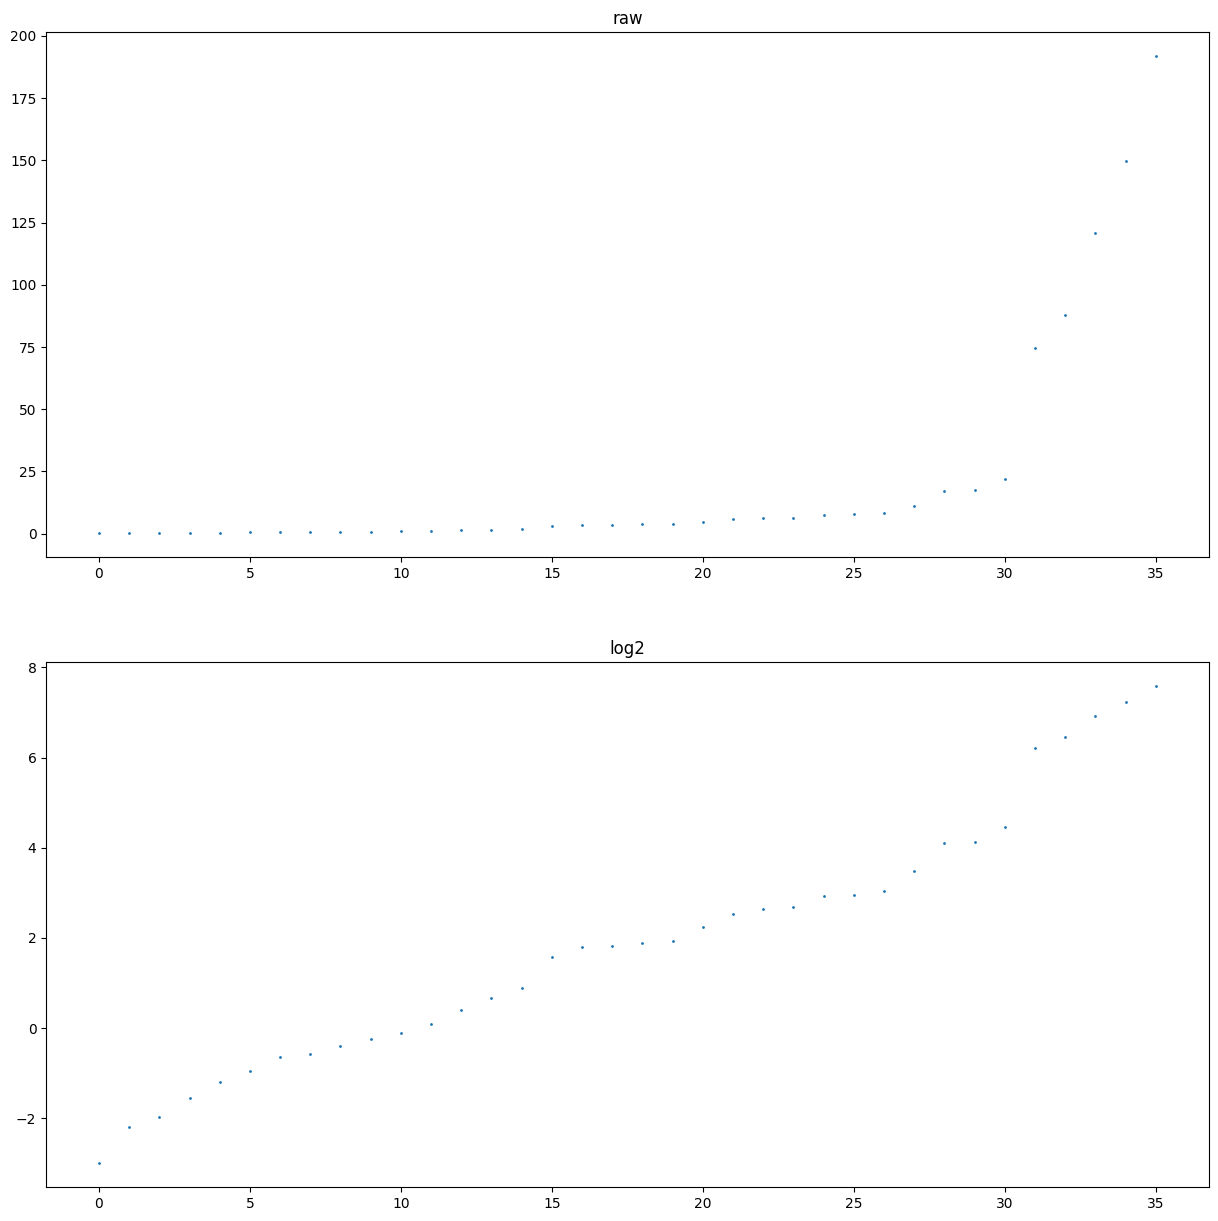

In [59]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
tmp_data = np.array(list(class_weight_dct.values()))
tmp_idx = np.argsort(tmp_data)
axs[0].scatter(np.arange(len(tmp_idx)), tmp_data[tmp_idx], s=1)
axs[0].set_title('raw')

axs[1].scatter(np.arange(len(tmp_idx)), np.log2(tmp_data)[tmp_idx], s=1)
axs[1].set_title('log2')

In [131]:
import numpy as np
from sklearn import linear_model
clf = linear_model.SGDClassifier(
    loss='modified_huber',
    random_state=100,
    class_weight=class_weight_dct,
    
    n_iter_no_change=5,
    max_iter=5000, 
    tol=1e-5
)

In [132]:
class_idx

array([  6,  12,  14, 193, 253, 299, 336, 342, 359, 383, 387, 403, 412,
       413, 418, 425, 441, 490, 494, 559, 566, 578, 600, 611, 613, 642,
       731, 739, 740, 799, 826, 859, 871, 909, 977, 993])

In [76]:
hdf5_path = os.path.join(ROOT_DIR, 'camel_2', str(2706), 'raw.hdf5')
k = h5py.File(hdf5_path)

In [77]:
k['expression'].keys()

<KeysViewHDF5 ['indices', 'indptr', 'lognorm']>

In [79]:
TRAINED_STUDIES.index('2706')

88

In [133]:
for i in range(len(TRAINED_STUDIES)):
    study_idx = TRAINED_STUDIES[i]
    
    print(study_idx, '- start')
    
    tmp_meta_arr = new_tree_major[new_tree_studies_idx_arr == i]
    tmp_cell_bool = tmp_meta_arr > 0
    if np.sum(tmp_cell_bool) == 0:
        print ('!!!!!WARNING: No metadata, skip study:', study_idx)
        continue
    
    hdf5_path = os.path.join(ROOT_DIR, 'camel_2', str(study_idx), 'raw.hdf5')
    with h5py.File(hdf5_path) as f:
        bc = f['barcodes'][()]
        fe = f['features'][()]
        indptr = f['expression']['indptr'][()].astype(np.int32)
        indices = f['expression']['indices'][()].astype(np.int32)
        try:
            raw = f['expression']['raw'][()].astype(np.float32)
        except:
            raw = f['expression']['lognorm'][()].astype(np.float32)

    print(study_idx, '- create_matrix')
    tmp_mtx = scipy.sparse.csr_matrix((raw, indices, indptr), shape=(len(fe), len(bc)))
    tmp_mtx = tmp_mtx.T.tocsr()

    print(study_idx, '- lognormalize matrix')
    is_raw_matrix = False
    if (not np.all(raw.astype('int') == raw) and np.sum(raw > 30) > 0) or np.all(raw.astype('int') == raw):
        is_raw_matrix = True

    if is_raw_matrix:
        tmp_mtx = normalize_total(tmp_mtx)
    else:
        tmp_mtx = convert_library_size(tmp_mtx)

    if tmp_mtx is None:
        print ('!!!!!WARNING: Cannot lognormalize, Skip study:', study_idx)
        continue
    # print (tmp_mtx.shape)
    # print (np.nonzero(tmp_cell_bool)[0])
    # print (np.nonzero(genes_bool)[0])
    tmp_mtx = tmp_mtx[
        np.nonzero(tmp_cell_bool)[0],
        :
    ]
    tmp_mtx = tmp_mtx[
        :,
        np.nonzero(new_tree_genes_bool)[0]
    ]
    # print (np.unique(tmp_meta_arr[tmp_cell_bool]))
    print(study_idx, '- partial_fit')
    clf.partial_fit(
        tmp_mtx, 
        tmp_meta_arr[tmp_cell_bool], 
        classes=class_idx
    )

1640 - start
1640 - create_matrix
1640 - lognormalize matrix
1640 - partial_fit
1647 - start
1647 - create_matrix
1647 - lognormalize matrix
1647 - partial_fit
1668 - start
1668 - create_matrix
1668 - lognormalize matrix
1668 - partial_fit
1671 - start
1671 - create_matrix
1671 - lognormalize matrix
1671 - partial_fit
1682 - start
1682 - create_matrix
1682 - lognormalize matrix
1682 - partial_fit
1683 - start
1683 - create_matrix
1683 - lognormalize matrix
1683 - partial_fit
1694 - start
1694 - create_matrix
1694 - lognormalize matrix
1694 - partial_fit
1697 - start
1697 - create_matrix
1697 - lognormalize matrix
1697 - partial_fit
1699 - start
1699 - create_matrix
1699 - lognormalize matrix
1699 - partial_fit
1703 - start
1703 - create_matrix
1703 - lognormalize matrix
1703 - partial_fit
1725 - start
!!!!!WARNING: No metadata, skip study: 1725
1731 - start
1731 - create_matrix
1731 - lognormalize matrix
1731 - partial_fit
1736 - start
!!!!!WARNING: No metadata, skip study: 1736
1749 -

In [ ]:
studies_idx_arr = []
for i in range(len(TRAINED_STUDIES)):
    study_idx = TRAINED_STUDIES[i]
    hdf5_path = os.path.join(ROOT_DIR, 'camel', str(study_idx), 'raw.hdf5')
    with h5py.File(hdf5_path) as f:
        bc = f['barcodes'][()]
    tmp = np.zeros(shape=len(bc))
    tmp[:] = i
    studies_idx_arr.append(tmp)

In [ ]:
studies_idx_arr = np.concatenate(studies_idx_arr)
studies_idx_arr = studies_idx_arr.astype('int')
studies_idx_arr = studies_idx_arr[np.nonzero(meta != 0)[0]]

In [ ]:
# studies_idx_arr = np.concatenate(studies_idx_arr)
# studies_idx_arr = studies_idx_arr.astype('int')
# np.save('trained_data_2/studies_idx_arr.npy', studies_idx_arr)

In [ ]:
studies_idx_arr

In [ ]:
np.array(TRAINED_STUDIES)

In [ ]:
for i in np.unique(studies_idx_arr):
    print (i)
    tmp_bool = np.nonzero(studies_idx_arr == i)[0]
    tmp_matrix = final_matrix[tmp_bool, :] 
    tmp_matrix.indptr = tmp_matrix.indptr.astype(np.int32)
    tmp_matrix.indices = tmp_matrix.indices.astype(np.int32)
    tmp_meta = meta[tmp_bool]
    clf.partial_fit(tmp_matrix, tmp_meta, classes=np.unique(meta))

In [134]:
import pickle

filename = 'trained_data_2/new_tree_rerun_meta_SGD_partial_fit_study_batch_HVG_log2_meta_weight_modified_huber_5000iter_tol_1e-5.sav'
pickle.dump(clf, open(filename, 'wb'))

In [301]:
clf

SGDClassifier(class_weight={6: 0.5161031066659924, 12: 0.12478399569558163,
                            14: 0.3395027136054563, 193: 74.55262557077626,
                            253: 6.2101194325054205, 299: 3.7195637316323045,
                            336: 2.9604222951533066, 342: 1.3152424337626976,
                            359: 0.6721678790947753, 383: 8.17741410397676,
                            387: 0.8405680144976782, 403: 7.7555695420862625,
                            412: 17.396936600958977, 413: 0.21940414135265193,
                            418: 0...
                            441: 4.726716750622431, 490: 0.7608332479006868,
                            494: 3.8351557361646154, 559: 0.4386273271901781,
                            566: 149.92676767676767, 578: 17.269965094140048,
                            600: 1.8559553716565687, 611: 87.73253627082214,
                            613: 6.467941607574377, 642: 0.2542587932264203,
                            731: 0.6367521284188276, 739: 11.215927045407708,
                            740: 120.76201923076923, 799: 3.496525323910483, ...},
              loss='modified_huber', random_state=100)

In [7]:
clf = pickle.load(open('trained_data_2/new_tree_SGD_partial_fit_study_batch_HVG_meta_weight_modified_huber_5000iter_tol_1e-5.sav', 'rb'))

In [135]:
clf

SGDClassifier(class_weight={6: 1.1842017740021005, 12: 1.0,
                            14: 1.5974227669622851, 193: 5.5593383898923125,
                            253: 1.9073988510601705, 299: 2.8333740782254404,
                            336: 2.6260819835890605, 342: 1.5626702334895612,
                            359: 1.25920171388713, 383: 3.108160994982181,
                            387: 1.3586107523167308, 403: 7.595943288076582,
                            412: 4.230607756128771, 413: 1.043718150441595,
                            418: 1.3370346196360086, 42...
                            441: 2.2255176337386597, 490: 1.3191474380612014,
                            494: 2.2492693108072697, 559: 1.1959635743388104,
                            566: 2.9081895206434645, 578: 4.28115663632674,
                            600: 2.257970088167475, 611: 6.222762439217252,
                            613: 2.875833426385483, 642: 1.070642619875709,
                            731: 1.2329936555875527, 739: 3.4919082143476925,
                            740: 2.517263284918476, 799: 2.1424375251397754, ...},
              loss='modified_huber', max_iter=5000, random_state=100,
              tol=1e-05)

In [151]:
with h5py.File('../inference_dir/2154/raw.hdf5') as f:
    indptr = f['expression']['indptr'][()].astype(np.int32)
    indices = f['expression']['indices'][()].astype(np.int32)
    data = f['expression']['raw'][()]
    bc = f['barcodes'][()]
    fe = f['features'][()]

In [152]:
mtx = scipy.sparse.csr_matrix((data, indices, indptr), shape=(len(fe), len(bc))).T.tocsr()

In [153]:
mtx.data

array([1., 4., 1., ..., 1., 3., 1.])

In [339]:
mtx = convert_library_size(mtx)

In [154]:
mtx = normalize_total(mtx)

In [155]:
mtx = mtx[:, :N_GENES][:, np.nonzero(new_tree_genes_bool)[0]]

In [156]:
mtx.shape

(52764, 28505)

In [157]:
res = clf.predict(mtx)
proba_res = clf.predict_proba(mtx)

for i in range(len(res)):
    ct_idx = res[i]
    arr_idx = np.nonzero(clf.classes_ == ct_idx)[0]
    if proba_res[i, arr_idx] < 0.99:
        res[i] = 0

In [158]:
import pandas as pd

In [159]:
TERM_MAPPING = read_compressed_json('/home/ub-sonvo-25d094476064960/term_mapping.json.gz')

In [160]:
res = [TERM_MAPPING['idx2name'][i] for i in res]
res

['ciliated cell',
 'Unassigned',
 'pneumocyte',
 'dendritic cell',
 'monocyte',
 'innate lymphoid cell',
 'innate lymphoid cell',
 'monocyte',
 'innate lymphoid cell',
 'Unassigned',
 'endothelial cell',
 'CD4-positive, alpha-beta T cell',
 'innate lymphoid cell',
 'pneumocyte',
 'pneumocyte',
 'innate lymphoid cell',
 'Unassigned',
 'endothelial cell',
 'endothelial cell',
 'innate lymphoid cell',
 'ciliated cell',
 'pneumocyte',
 'CD4-positive, alpha-beta T cell',
 'Unassigned',
 'Unassigned',
 'endothelial cell',
 'pneumocyte',
 'macrophage',
 'Unassigned',
 'Unassigned',
 'Unassigned',
 'Unassigned',
 'Unassigned',
 'Unassigned',
 'endothelial cell',
 'endothelial cell',
 'endothelial cell',
 'innate lymphoid cell',
 'Unassigned',
 'Unassigned',
 'endothelial cell',
 'Unassigned',
 'CD4-positive, alpha-beta T cell',
 'innate lymphoid cell',
 'innate lymphoid cell',
 'endothelial cell',
 'Unassigned',
 'pneumocyte',
 'innate lymphoid cell',
 'endothelial cell',
 'pneumocyte',
 'inna

In [161]:
import pandas as pd

In [162]:
df = pd.DataFrame({'new_tree_SGD_partial_fit_study_batch_HVG_meta_weight_modified_huber_5000iter_tol_1e-5': res}, index=bc.astype('str'))

In [163]:
df.index.name = 'Barcodes'
df.to_csv('test_meta.tsv', sep='\t')

In [ ]:
meta.shape

In [ ]:
np.sum(meta == 616) / len(meta)

In [ ]:
np.sum(meta == 342) / len(meta)

In [ ]:
np.sum(meta == 387) / len(meta)

In [ ]:
x, y = np.unique(meta, return_counts=True)
x = x[np.argsort(y)]
y = y[np.argsort(y)]

In [ ]:
for i in range(len(x)):
    print (TERM_MAPPING['idx2name'][x[i]], y[i] / len(meta))

In [ ]:
y 

____